# Importing Libraries

In [6]:
import sys
import os
import os
import shutil
import tqdm
import requests
import time
from functools import wraps
import traceback
tqdm.monitor_interval = 0
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import keras_utils
from keras_utils import reset_tf_session 
import sys
import os
import os
import shutil
import tqdm
import requests
import time
from functools import wraps
import traceback
tqdm.monitor_interval = 0
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
from __future__ import print_function
import os,time,cv2, sys, math
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import time, datetime
import argparse
import random
import os, sys
import subprocess
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itertools
import operator
import os, csv
import tensorflow as tf

def link_all_files_from_dir(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    if not os.path.exists(src_dir):
        src_dir = src_dir.replace("readonly", "readonly/readonly")
    for fn in os.listdir(src_dir):
        src_file = os.path.join(src_dir, fn)
        dst_file = os.path.join(dst_dir, fn)
        if os.name == "nt":
            shutil.copyfile(src_file, dst_file)
        else:
            if os.path.islink(dst_file):
                os.remove(dst_file)
            os.symlink(os.path.abspath(src_file), dst_file)
link_all_files_from_dir("models/", os.path.expanduser("~/.keras/models"))

print(tf.__version__)
print(keras.__version__)

1.10.0
2.2.4


# Architecture

![title](img/FlowChart.png)

# Prepare Images for Model

![title](img/center_crop.jpg)

In [7]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

def decode_image_from_raw_bytes(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    """
    cropped_img = img[int((img.shape[0] - min(img.shape[0], img.shape[1]))/2): int((img.shape[0] + min(img.shape[0], img.shape[1]))/2), int((img.shape[1] - min(img.shape[0], img.shape[1]))/2): int((img.shape[1] + min(img.shape[0], img.shape[1]))/2), :]
    
    return cropped_img

def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = image_center_crop(raw_bytes)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

(256, 256, 3)


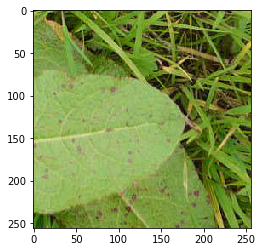

(250, 250, 3)


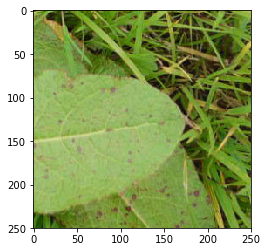

In [9]:
# test cropping
import cv2
import matplotlib.pyplot as plt
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/train/docks/3112_14280_24573.jpg")
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# Weed Classification

# ---------------------------------------------------------------------------------------------------------------

![title](img/Classification.png)

## Prepare Data for Classification

In [7]:
# read all filenames and labels for them
from os import listdir
from os.path import isfile, join
import glob
from keras.preprocessing.image import ImageDataGenerator

# Training set
mypath = '../Dataset/Open_Sprayer_Images_Classification/train/docks/'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
tr_files_original = []
tr_labels_original = []
for file in files:
    img = decode_image_from_raw_bytes(join(mypath,file))
    img = prepare_raw_bytes_for_model(img)
    tr_files_original.append(img)
    tr_labels_original.append(0)

In [8]:
# Data Augmentation
'''
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)    

# the .flow() command below generates batches of randomly transformed images

i = 0
for i in range(5000):
    idx = np.random.randint(len(tr_files_original))
    for batch in datagen.flow(np.expand_dims(tr_files_original[idx], axis=0), batch_size=1,
                              save_to_dir='../Dataset/Open_Sprayer_Images_Classification/train/docks_augmented/', save_prefix='aug', save_format='jpeg'):
        break
'''

"\ndatagen = ImageDataGenerator(\n        rescale=1./255,\n        shear_range=0.2,\n        zoom_range=0.2,\n        horizontal_flip=True)    \n\n# the .flow() command below generates batches of randomly transformed images\n\ni = 0\nfor i in range(5000):\n    idx = np.random.randint(len(tr_files_original))\n    for batch in datagen.flow(np.expand_dims(tr_files_original[idx], axis=0), batch_size=1,\n                              save_to_dir='../../Datasets/Open_Sprayer_Images/train/docks_augmented/', save_prefix='aug', save_format='jpeg'):\n        break\n"

In [9]:
mypath = '../Dataset/Open_Sprayer_Images_Classification/train/docks_augmented/'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
for file in files:
    img = decode_image_from_raw_bytes(join(mypath,file))
    img = prepare_raw_bytes_for_model(img)
    tr_files_original.append(img)
    tr_labels_original.append(0)
    
mypath = '../Dataset/Open_Sprayer_Images_Classification/train/notdocks/'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
for file in files:
    img = decode_image_from_raw_bytes(join(mypath,file))
    img = prepare_raw_bytes_for_model(img)
    tr_files_original.append(img)
    tr_labels_original.append(1)

# Validation set
mypath = '../Dataset/Open_Sprayer_Images_Classification/valid/docks/'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
te_files = []
te_labels = []
for file in files:
    img = decode_image_from_raw_bytes(join(mypath,file))
    img = prepare_raw_bytes_for_model(img)
    te_files.append(img)
    te_labels.append(0)

mypath = '../Dataset/Open_Sprayer_Images_Classification/valid/notdocks/'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
for file in files:
    img = decode_image_from_raw_bytes(join(mypath,file))
    img = prepare_raw_bytes_for_model(img)
    te_files.append(img)
    te_labels.append(1)

# Random shuffling
from random import shuffle
tr_files = []
tr_labels = []
index_shuf = np.arange(len(tr_files_original))
shuffle(index_shuf)
for i in index_shuf:
    tr_files.append(tr_files_original[i])
    tr_labels.append(tr_labels_original[i])
    
print(np.array(tr_files).shape)
print(np.array(tr_labels).shape)
print(np.array(te_files).shape)
print(np.array(te_labels).shape)

(9840, 250, 250, 3)
(9840,)
(670, 250, 250, 3)
(670,)


(32, 250, 250, 3) (32, 2)


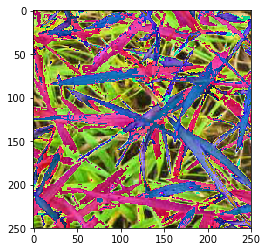

In [11]:
BATCH_SIZE = 32
def train_generator(files, labels):
    i = 0
    while True:  # so that Keras can loop through this as long as it wants
        # prepare batch images
        batch_imgs = np.array(files[i:i+BATCH_SIZE])
        if(batch_imgs.shape[0] == 0):
            break
        batch_targets = np.array(labels[i:i+BATCH_SIZE])
        # stack images into 4D tensor [batch_size, img_size, img_size, 3]
        # convert targets into 2D tensor [batch_size, num_classes]
        batch_targets = keras.utils.np_utils.to_categorical(batch_targets, 2)
        i += BATCH_SIZE
        yield batch_imgs, batch_targets
    
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(_[0][0])
    break

## Training

In [12]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(2, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

model = inception()

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 28, 28, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 28, 28, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 28, 28, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 28, 28, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 28, 28, 64)   0           batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 13, 13, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 13, 13, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 13, 13, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 13, 13, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 13, 13, 192)  0           batch_normalization_41[0][0]     
__________

batch_normalization_74 (BatchNo (None, 13, 13, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 13, 13, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 13, 13, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 13, 13, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 13, 13, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            4098        global_average_pooling2d_1[0][0] 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [16]:
# how many layers our model has
print(len(model.layers))

313


In [17]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False
    
# compile new model
model.compile(
    loss='binary_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

# we will save model checkpoints to continue training in case of kernel death
model_filename = 'weights/agriculture.{0:03d}.hdf5'
last_finished_epoch = None

In [20]:
from keras.models import load_model
last_finished_epoch = 3
model = load_model(model_filename.format(last_finished_epoch))

In [21]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
'''
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(), 
               keras_utils.ModelSaveCallback(model_filename)],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)
'''

'\nmodel.fit_generator(\n    train_generator(tr_files, tr_labels), \n    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,\n    epochs=2 * 8,\n    validation_data=train_generator(te_files, te_labels), \n    validation_steps=len(te_files) // BATCH_SIZE // 4,\n    callbacks=[keras_utils.TqdmProgressCallback(), \n               keras_utils.ModelSaveCallback(model_filename)],\n    verbose=0,\n    initial_epoch=last_finished_epoch or 0\n)\n'

## CNN + SVM Classifier

In [22]:
from sklearn.svm import SVC
from keras.models import Model
svm = SVC(kernel='rbf', probability=True)
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d_1').output)

In [23]:
# Generate Feature Matrix
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d_1').output)
feature_matrix = []
for item in tr_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    feature_matrix.append(feat_train)
np.array(feature_matrix)

import pandas as pd
feature_matrix = np.reshape(np.array(feature_matrix), (9840, 2048))
pd.DataFrame(np.array(feature_matrix)).to_csv("features.csv")

array([[[1.9675104e-01, 1.7257915e-01, 0.0000000e+00, ...,
         0.0000000e+00, 4.0379548e-01, 3.4100112e-01]],

       [[3.7617717e-02, 3.7227672e-02, 1.4621057e-01, ...,
         1.6586129e-01, 5.8385704e-02, 1.1281068e+00]],

       [[4.4866605e-04, 0.0000000e+00, 8.2815605e-01, ...,
         6.1813933e-01, 3.4063875e-03, 1.6940763e+00]],

       ...,

       [[2.3983167e-02, 3.8804844e-02, 2.0633714e-01, ...,
         5.7873988e-01, 7.7885456e-02, 2.1494508e+00]],

       [[1.4180064e-01, 2.1934241e-01, 9.0755843e-02, ...,
         0.0000000e+00, 2.8542975e-01, 5.7221198e-01]],

       [[5.7792876e-02, 1.4826287e-02, 2.3523463e-02, ...,
         5.5913082e-03, 8.8882074e-02, 1.7142967e+00]]], dtype=float32)

In [ ]:
# Load generated feature matrix
import pandas as pd
test_fm = pd.read_csv('features.csv', index_col = 0).values

In [26]:
# Train and Save SVM Model
import pickle
from sklearn import model_selection
svm.fit(test_fm,tr_labels)
print('fitting done !!!')
filename = 'models/finalized_svm_model.sav'
pickle.dump(svm, open(filename, 'wb'))

In [27]:
# load the model from disk
#import pickle
#filename = 'models/finalized_svm_model.sav'
#svm = pickle.load(open(filename, 'rb'))

### Prediction Test

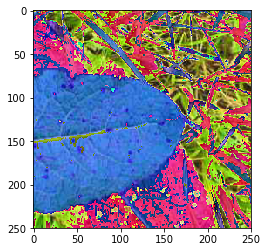

array([[9.9998581e-01, 1.4232132e-05]], dtype=float32)

In [28]:
# Prediction with CNN + Softmax
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/train/docks/3112_14280_24573.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model.predict(img)
prediction

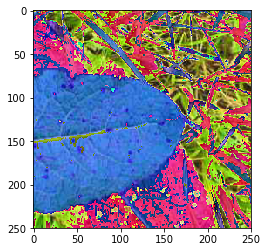

array([0])

In [29]:
# Prediction with CNN + SVM
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/train/docks/3112_14280_24573.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = svm.predict(prediction)
prediction

In [31]:
# CNN + SVM
import sklearn

val_feature_matrix = []
for item in te_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(svm.score(test_fm,tr_labels)) + '\n')
print('Validation Accuracy: ' + str(svm.score(val_feature_matrix,te_labels)))

Train Accuracy: 0.9282520325203252

Validation Accuracy: 0.9059701492537313


In [32]:
# CNN
train_predictions = []
for i,file in enumerate(tr_files):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    train_predictions.append(prediction)
    
test_predictions = []
for i,file in enumerate(te_files):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    test_predictions.append(prediction)

import sklearn
train_acc = sklearn.metrics.accuracy_score(np.array(train_predictions), 
                                     np.array(tr_labels))
test_acc = sklearn.metrics.accuracy_score(np.array(test_predictions), 
                                     np.array(te_labels))

print('Train Accuray:' + str(train_acc) + '\n') 
print('Validation Accuray:' + str(test_acc))  

Train Accuray:0.7269308943089431

Validation Accuray:0.5522388059701493


## CNN + Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from keras.models import Model
import pandas as pd

rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d_1').output)
'''
feature_matrix = []
for item in tr_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    feature_matrix.append(feat_train)
np.array(feature_matrix)
'''

test_fm = pd.read_csv('features.csv', index_col = 0).values
rf.fit(test_fm,tr_labels)
print('fitting done !!!')

# Save RF Model
import pickle
from sklearn import model_selection
filename = 'models/finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


fitting done !!!


In [34]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Prediction Test

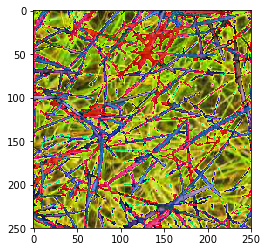

array([[0.2955207, 0.7044793]], dtype=float32)

In [35]:
# Prediction with CNN + Softmax
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/valid/notdocks/347_22859_1880.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model.predict(img)
prediction

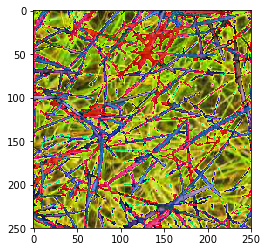

array([1])

In [36]:
# Prediction with CNN + Random Forests Classifier
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/valid/notdocks/347_22859_1880.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = rf.predict(prediction)
prediction

In [38]:
# CNN + RF
import sklearn

val_feature_matrix = []
for item in te_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(rf.score(test_fm,tr_labels)) + '\n')
print('Validation Accuracy: ' + str(rf.score(val_feature_matrix,te_labels)))

Train Accuracy: 0.9470528455284553

Validation Accuracy: 0.9074626865671642


## CNN + Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
from keras.models import Model
import pandas as pd

dt = DecisionTreeClassifier(random_state=0)
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d_1').output)
'''
feature_matrix = []
for item in tr_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    feature_matrix.append(feat_train)
np.array(feature_matrix)
'''

test_fm = pd.read_csv('features.csv', index_col = 0).values
dt.fit(test_fm,tr_labels)
print('fitting done !!!')

# Save DT Model
import pickle
from sklearn import model_selection
filename = 'models/finalized_dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

fitting done !!!


In [40]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Prediction Test

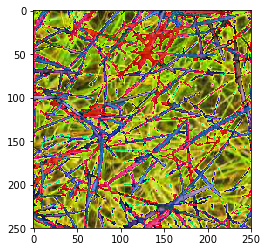

array([[0.2955207, 0.7044793]], dtype=float32)

In [41]:
# Prediction with CNN + Softmax
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/valid/notdocks/347_22859_1880.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model.predict(img)
prediction

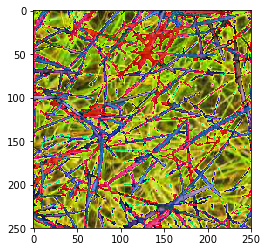

array([1])

In [42]:
# Prediction with CNN + Decision Tree Classifier
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Images_Classification/valid/notdocks/347_22859_1880.jpg")
img = prepare_raw_bytes_for_model(img)
plt.imshow(img)
plt.show()
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]])
prediction = model_feat.predict(img)
prediction = dt.predict(prediction)
prediction

In [44]:
# CNN + DT
import sklearn

val_feature_matrix = []
for item in te_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    val_feature_matrix.append(feat_train)
val_feature_matrix = np.array(val_feature_matrix)[:,0,:]

print('Train Accuracy: ' + str(dt.score(test_fm,tr_labels)) + '\n')
print('Validation Accuracy: ' + str(dt.score(val_feature_matrix,te_labels)))

Train Accuracy: 1.0

Validation Accuracy: 0.9


## ROC Curves

AUC(SVM): 0.879
AUC(RF): 0.897
AUC(DT): 0.853
AUC(Softmax): 0.782


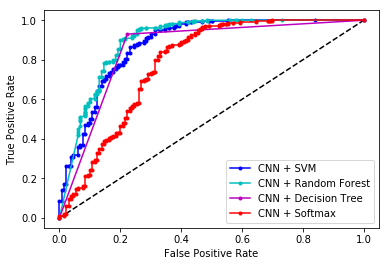

In [46]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# CNN + SVM
probs = svm.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(te_labels, probs)
print('AUC(SVM): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(te_labels, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--', color = 'k')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + SVM', color = 'b')

# CNN + RF
probs = rf.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(te_labels, probs)
print('AUC(RF): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(te_labels, probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Random Forest', color = 'c')

# CNN + DT
probs = dt.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(te_labels, probs)
print('AUC(DT): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(te_labels, probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Decision Tree', color = 'm')


# CNN + Softmax
probs = []
for i,file in enumerate(te_files):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    probs.append(prediction)
probs = np.array(probs)
probs = np.reshape(probs, (probs.shape[0],2))
probs = probs[:,1]
auc = roc_auc_score(te_labels, probs)
print('AUC(Softmax): %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(te_labels, probs)
# plot no skill
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CNN + Softmax', color = 'r')


# show the plot
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
pyplot.show()

## Precision-Recall Curves

CNN + SVM: f1=0.944 ap=0.957
CNN + RF: f1=0.944 ap=0.958
CNN + DT: f1=0.937 ap=0.936
CNN + Softmax: f1=0.641 ap=0.905


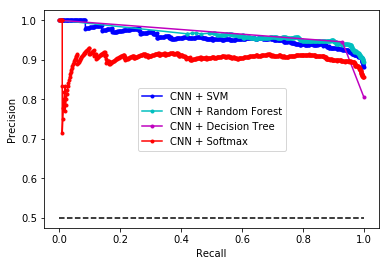

In [47]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

# CNN + SVM
probs = svm.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = svm.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(te_labels, probs)
# calculate F1 score
f1 = f1_score(te_labels, yhat)
# calculate average precision score
ap = average_precision_score(te_labels, probs)
print('CNN + SVM: f1=%.3f ap=%.3f' % (f1, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--', color='k')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + SVM', color='b')

# CNN + RF
probs = rf.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = rf.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(te_labels, probs)
# calculate F1 score
f1 = f1_score(te_labels, yhat)
# calculate average precision score
ap = average_precision_score(te_labels, probs)
print('CNN + RF: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Random Forest', color='c')

# CNN + DT
probs = dt.predict_proba(val_feature_matrix)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = dt.predict(val_feature_matrix)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(te_labels, probs)
# calculate F1 score
f1 = f1_score(te_labels, yhat)
# calculate average precision score
ap = average_precision_score(te_labels, probs)
print('CNN + DT: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Decision Tree', color='m')

# CNN + Softmax
probs = []
for i,file in enumerate(te_files):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    probs.append(prediction)
probs = np.array(probs)
probs = np.reshape(probs, (probs.shape[0],2))
probs = probs[:,1]

yhat = []
for i,file in enumerate(te_files):
    file = np.reshape(file, [1, file.shape[0], file.shape[1], file.shape[2]])
    prediction = model.predict(file)
    prediction = np.argmax(prediction)
    yhat.append(prediction)
probs = np.array(probs)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(te_labels, probs)
# calculate F1 score
f1 = f1_score(te_labels, yhat)
# calculate average precision score
ap = average_precision_score(te_labels, probs)
print('CNN + Softmax: f1=%.3f ap=%.3f' % (f1, ap))
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.', label='CNN + Softmax', color='r')

# show the plot
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
pyplot.show()

# Weed Segmentation

# ---------------------------------------------------------------------------------------------------------------

![title](img/UNet.png)

## Prepare images for Segmentation

(512, 512, 3)


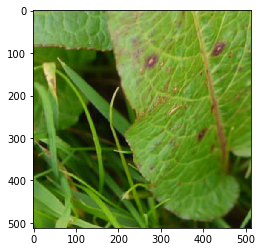

(512, 512, 3)


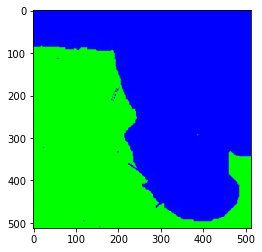

In [13]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 512

# Test Cropping
# For input image
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Docks_Segmentation/original_data/input/10001_31869_21227.jpg")
img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# For output mask
img = decode_image_from_raw_bytes("../Dataset/Open_Sprayer_Docks_Segmentation/original_data/output/10001_31869_21227.jpg")
img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()


## Preparing data for Segmentation

In [15]:
import cv2
import random
from os import listdir
from os.path import isfile, join
'''
def data_augmentation(input_image, output_image, name):
    
    # Horizontal flip
    input_image = cv2.flip(input_image, 1)
    output_image = cv2.flip(output_image, 1)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/input/'+str(name) +'_aug_hflip.png',input_image)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/output/'+str(name) +'_aug_hflip.png',output_image)

    # Vertical flip
    input_image = cv2.flip(input_image, 0)
    output_image = cv2.flip(output_image, 0)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/input/'+str(name) +'_aug_vflip.png',input_image)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/output/'+str(name) +'_aug_vflip.png',output_image)
    
    # Rotation
    angle = random.choice([-180,-90,90])
    M = cv2.getRotationMatrix2D((input_image.shape[1]//2, input_image.shape[0]//2), angle, 1.0)
    input_image = cv2.warpAffine(input_image, M, (input_image.shape[1], input_image.shape[0]), flags=cv2.INTER_NEAREST)
    output_image = cv2.warpAffine(output_image, M, (output_image.shape[1], output_image.shape[0]), flags=cv2.INTER_NEAREST)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/input/'+str(name) +'_aug_rotation.png',input_image)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/augmented_data/output/'+str(name) +'_aug_rotation.png',output_image)

# Training set
inputpath = '../Dataset/Open_Sprayer_Docks_Segmentation/original_data/input/'
outputpath = '../Dataset/Open_Sprayer_Docks_Segmentation/original_data/output/'
inputfiles = [ f for f in listdir(inputpath) if isfile(join(inputpath,f))]
outputfiles = [ f for f in listdir(outputpath) if isfile(join(outputpath,f))]
for file in inputfiles:
    input_img = decode_image_from_raw_bytes(join(inputpath,file))
    input_img = prepare_raw_bytes_for_model(input_img, normalize_for_model=False)
    
    output_img = decode_image_from_raw_bytes(join(outputpath,file))
    output_img = prepare_raw_bytes_for_model(output_img, normalize_for_model=False)
    
    data_augmentation(input_img,output_img,file.split('.')[0])

'''
# # Load Data

# In[23]:


#Splitting the data
import random

num_validation_files = 30
num_test_files = 10

path = '../Dataset/Open_Sprayer_Docks_Segmentation/all_data/input/'
files = [ f for f in listdir(path) if isfile(join(path,f))]

train_idx = np.arange(0,len(files))
validation_idx = []
for _ in range(num_validation_files):
    idx = random.choice(train_idx)
    validation_idx.append(idx)
    train_idx = list(set(train_idx) - set([idx]))
test_idx = []
for _ in range(num_test_files):
    idx = random.choice(train_idx)
    test_idx.append(idx)
    train_idx = list(set(train_idx) - set([idx]))

print("Total no. of samples: " + str(len(files)))
print("No. of training samples: " + str(len(train_idx)))
print("No. of validation samples: " + str(len(validation_idx)))
print("No. of test samples: " + str(len(test_idx)))

'''
inputpath = '../Dataset/Open_Sprayer_Docks_Segmentation/all_data/input/'
outputpath = '../Dataset/Open_Sprayer_Docks_Segmentation/all_data/output/'
inputfiles = [ f for f in listdir(inputpath) if isfile(join(inputpath,f))]
outputfiles = [ f for f in listdir(outputpath) if isfile(join(outputpath,f))]
# Training data
for idx in train_idx:
    input_img = decode_image_from_raw_bytes(join(inputpath,inputfiles[idx]))
    input_img = prepare_raw_bytes_for_model(input_img, normalize_for_model=False)
    output_img = decode_image_from_raw_bytes(join(outputpath,outputfiles[idx]))
    output_img = prepare_raw_bytes_for_model(output_img, normalize_for_model=False)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/train/'+str(inputfiles[idx]),input_img)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/train_labels/'+str(outputfiles[idx]),output_img)
    
# Validation data
for idx in validation_idx:
    input_img = decode_image_from_raw_bytes(join(inputpath,inputfiles[idx]))
    input_img = prepare_raw_bytes_for_model(input_img, normalize_for_model=False)
    output_img = decode_image_from_raw_bytes(join(outputpath,outputfiles[idx]))
    output_img = prepare_raw_bytes_for_model(output_img, normalize_for_model=False)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/val/'+str(inputfiles[idx]),input_img)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/val_labels/'+str(outputfiles[idx]),output_img)
    
# Testing data
for idx in test_idx:
    input_img = decode_image_from_raw_bytes(join(inputpath,inputfiles[idx]))
    input_img = prepare_raw_bytes_for_model(input_img, normalize_for_model=False)
    output_img = decode_image_from_raw_bytes(join(outputpath,outputfiles[idx]))
    output_img = prepare_raw_bytes_for_model(output_img, normalize_for_model=False)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/test/'+str(inputfiles[idx]),input_img)
    cv2.imwrite('../Dataset/Open_Sprayer_Docks_Segmentation/test_labels/'+str(outputfiles[idx]),output_img)

'''

# Load the data
def prepare_data(dataset_dir):
    train_input_names=[]
    train_output_names=[]
    val_input_names=[]
    val_output_names=[]
    test_input_names=[]
    test_output_names=[]
    for file in os.listdir(dataset_dir + "/train"):
        cwd = os.getcwd()
        train_input_names.append(cwd + "/" + dataset_dir + "/train/" + file)
    for file in os.listdir(dataset_dir + "/train_labels"):
        cwd = os.getcwd()
        train_output_names.append(cwd + "/" + dataset_dir + "/train_labels/" + file)
    for file in os.listdir(dataset_dir + "/val"):
        cwd = os.getcwd()
        val_input_names.append(cwd + "/" + dataset_dir + "/val/" + file)
    for file in os.listdir(dataset_dir + "/val_labels"):
        cwd = os.getcwd()
        val_output_names.append(cwd + "/" + dataset_dir + "/val_labels/" + file)
    for file in os.listdir(dataset_dir + "/test"):
        cwd = os.getcwd()
        test_input_names.append(cwd + "/" + dataset_dir + "/test/" + file)
    for file in os.listdir(dataset_dir + "/test_labels"):
        cwd = os.getcwd()
        test_output_names.append(cwd + "/" + dataset_dir + "/test_labels/" + file)
    train_input_names.sort(),train_output_names.sort(), val_input_names.sort(), val_output_names.sort(), test_input_names.sort(), test_output_names.sort()
    return train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names

print("Loading the data ...")
train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names = prepare_data('../Dataset/Open_Sprayer_Docks_Segmentation/')
train_input_names = train_input_names[:1000]
train_output_names = train_output_names[:1000]

Total no. of samples: 4172
No. of training samples: 4132
No. of validation samples: 30
No. of test samples: 10
Loading the data ...


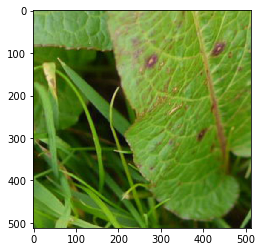

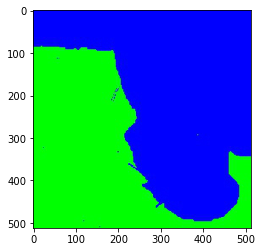

In [16]:
# Plot loaded data
img = decode_image_from_raw_bytes(train_input_names[0])
img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
plt.imshow(img)
plt.show()

img = decode_image_from_raw_bytes(train_output_names[0])
img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
plt.imshow(img)
plt.show()

In [17]:
import matplotlib
matplotlib.use('Agg')

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Training

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)

#Load training images
X_train = []
for filename in train_input_names:
    img = decode_image_from_raw_bytes(filename)
    img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
    X_train.append(img)
X_train = np.array(X_train)
      
Y_train = []
for filename in train_output_names:
    img = decode_image_from_raw_bytes(filename)
    img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
    test = img.astype("float32")  # prepare for normalization
    #Split into categories
    test = test[:,:,1:2]
    test[test < 100] = 1
    test[test >= 100] = 0
    Y_train.append(test)
Y_train = np.array(Y_train)

In [20]:
# UNET Architecture
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape, Permute, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.layers import concatenate, Dropout

def get_unet(rows, cols):
    inputs = Input((rows, cols,3))
    print("Input  : " + str(inputs))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3),padding='same')(up7)
    conv7 = Conv2D(128, (3, 3),padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1))(conv9)
    output = Activation("sigmoid")(conv10)
    model = Model(inputs=[inputs], outputs=[output])
    return model

In [21]:
import os
import glob
import numpy as np
import cv2

input_shape = (IMG_SIZE, IMG_SIZE, 3)
nb_classes = 1
nb_epoch = 100
batch_size = 1
model = get_unet(IMG_SIZE, IMG_SIZE)
print(model.summary())

Input  : Tensor("input_1:0", shape=(?, 512, 512, 3), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
_________________________________________

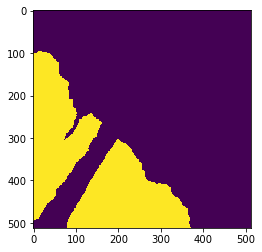

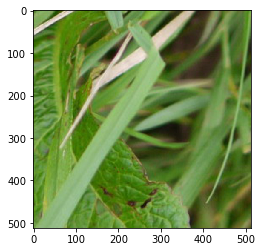

In [22]:
test = Y_train[4]
test = np.reshape(test, (IMG_SIZE, IMG_SIZE))
plt.imshow(test)
plt.show()
plt.imshow(X_train[4])
plt.show()

In [24]:
from keras import losses
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-5), loss = losses.mean_squared_error)

# Train and Save Model
#model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch)
#model.save('models/UNet.h5')

from keras.models import load_model
model = load_model('models/UNet.h5')

## Testing

IOU Score: 0.9948584651988983
IOU Score: 0.9332544350826371
IOU Score: 0.9833571203947846
IOU Score: 0.88967663020889
IOU Score: 0.7001319551352541
IOU Score: 0.9409120740574429
IOU Score: 0.6042153323423232
IOU Score: 0.8540698991729919
IOU Score: 0.9039251235801837
IOU Score: 0.9700490380988306
IOU Score: 0.9742134546040322
IOU Score: 0.8274002794340477
IOU Score: 0.812419116812351
IOU Score: 0.933709396532142
IOU Score: 0.8460359452422944
IOU Score: 0.27873129204997943
IOU Score: 0.6228054964399253
IOU Score: 0.8068437069777552
IOU Score: 0.6734914625666384
IOU Score: 0.9183988037039167


C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IOU Score: 0.7949380845738374
IOU Score: 0.8992582679507028
IOU Score: 0.9619359972566485
IOU Score: 0.6866375478334815
IOU Score: 0.5221164731038531
IOU Score: 0.9005666486778198
IOU Score: 0.9107559496033598
IOU Score: 0.8257235540214514
IOU Score: 0.6698055018709651
IOU Score: 0.9815822874065717
IOU Score: 0.38099407674478497
IOU Score: 0.8049344978165939
IOU Score: 0.4963801460212283
IOU Score: 0.8162192858971078
IOU Score: 0.5481425668424778
IOU Score: 0.5405498995775331
IOU Score: 0.7298746353386423
IOU Score: 0.9518492068644636
IOU Score: 0.9446191541168298


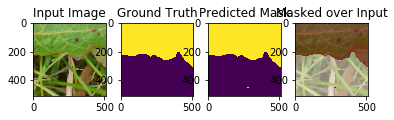

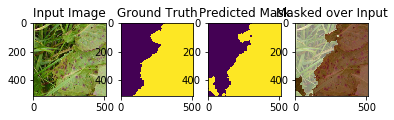

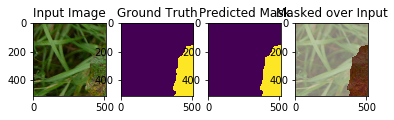

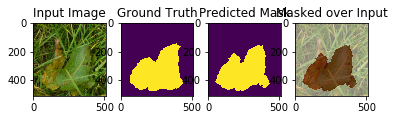

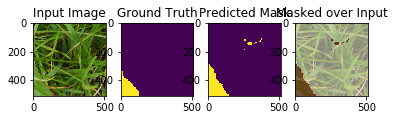

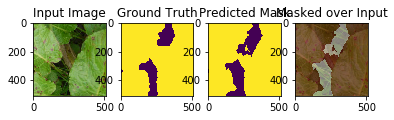

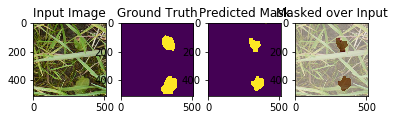

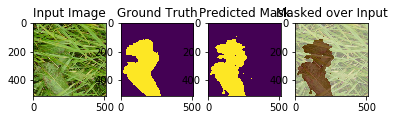

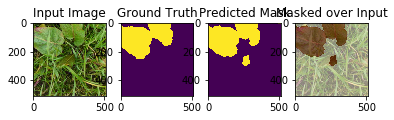

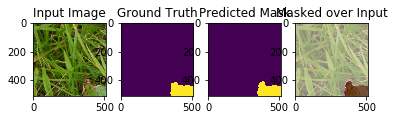

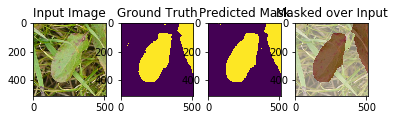

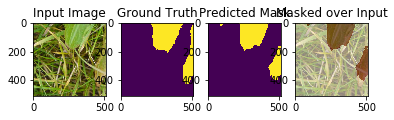

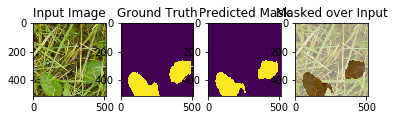

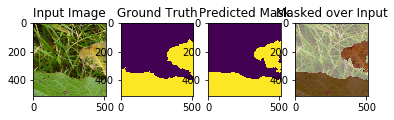

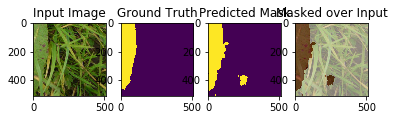

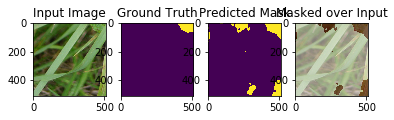

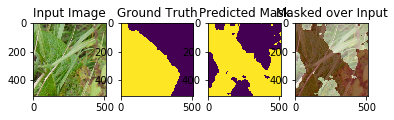

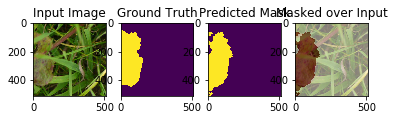

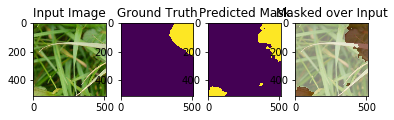

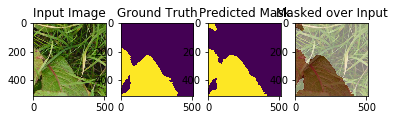

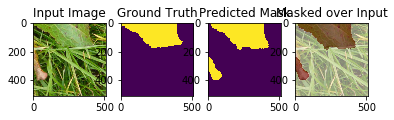

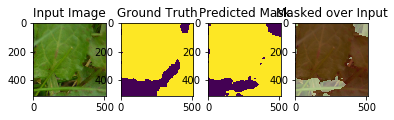

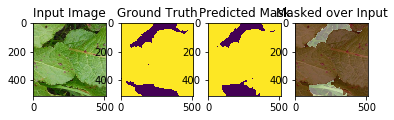

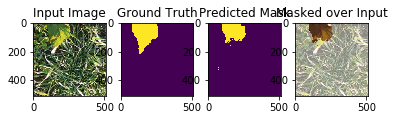

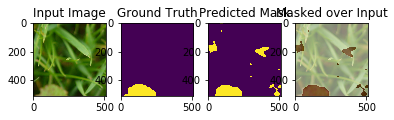

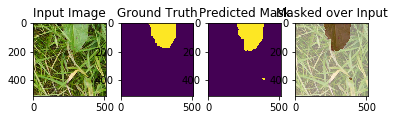

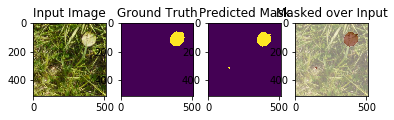

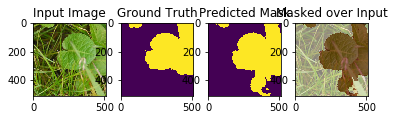

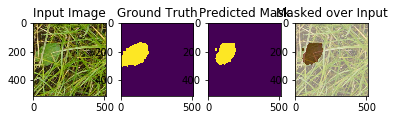

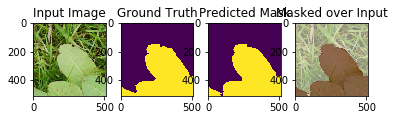

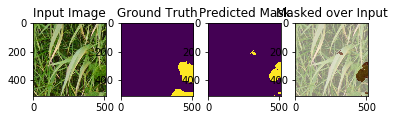

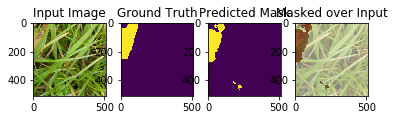

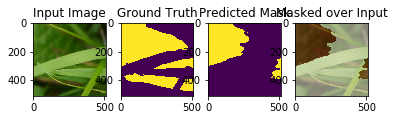

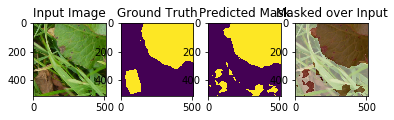

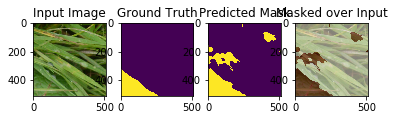

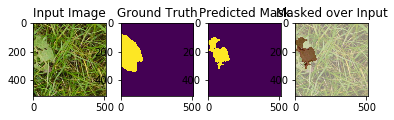

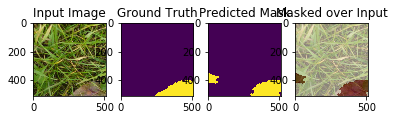

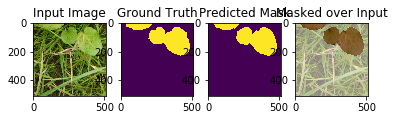

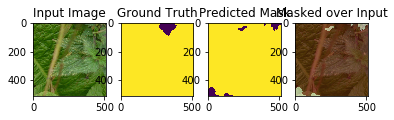

In [26]:
#Load validation images
X_test = []
for filename in val_input_names:
    img = decode_image_from_raw_bytes(filename)
    img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
    X_test.append(img)
X_test = np.array(X_test)
      
Y_test = []
for filename in val_output_names:
    img = decode_image_from_raw_bytes(filename)
    img = prepare_raw_bytes_for_model(img, normalize_for_model=False)
    test = img.astype("float32")  # prepare for normalization
    #Split into categories
    test = test[:,:,1:2]
    test[test < 100] = 1
    test[test >= 100] = 0
    Y_test.append(test)
Y_test = np.array(Y_test)

for i in range(X_test.shape[0]):
    plt.figure()
    plt.subplot(1,4,1)
    plt.title("Input Image")
    plt.imshow(X_test[i])
    plt.subplot(1,4,2)
    test = np.reshape(Y_test[i], (IMG_SIZE, IMG_SIZE))
    plt.imshow(test)
    plt.title("Ground Truth")
    plt.subplot(1,4,3)
    test = np.reshape(X_test[i], (-1, IMG_SIZE, IMG_SIZE, 3))
    predictions = model.predict(test)
    predictions = np.reshape(predictions, (IMG_SIZE, IMG_SIZE))
    predictions = np.round(predictions)
    plt.imshow(predictions)
    plt.title("Predicted Mask")
    
    # Mask
    plt.subplot(1,4,4)
    test = np.reshape(Y_test[i], (IMG_SIZE, IMG_SIZE))
    plt.imshow(X_test[i])
    plt.imshow(predictions, 'Reds', alpha=0.5)
    plt.title("Masked over Input")
    intersection = np.logical_and(test, predictions)
    union = np.logical_or(test, predictions)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IOU Score: ' + str(iou_score))

## CRF Post-Processing

C:\Users\Rohit\AppData\Roaming\Python\Python36\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Rohit\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mean IOU Score Before CRF: 0.7906508412603506
Mean IOU Score After CRF: 0.7967682594643776
Min IOU Score Before CRF: 0.27873129204997943
Min IOU Score After CRF: 0.3354648303000492
Max IOU Score Before CRF: 0.9948584651988983
Max IOU Score After CRF: 0.9949135963482231


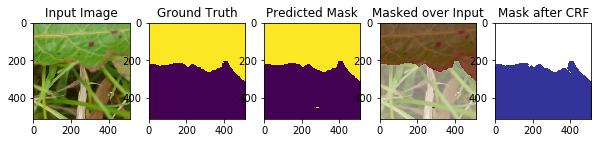

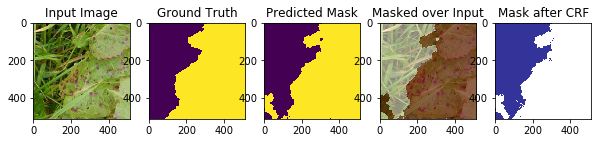

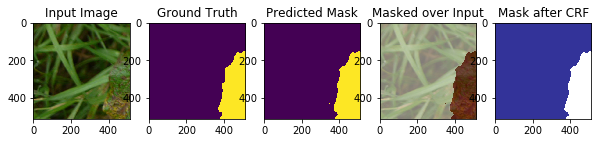

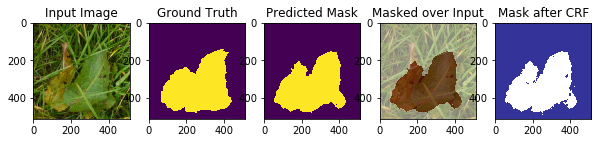

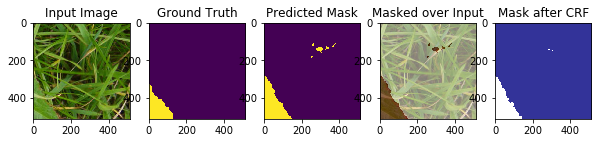

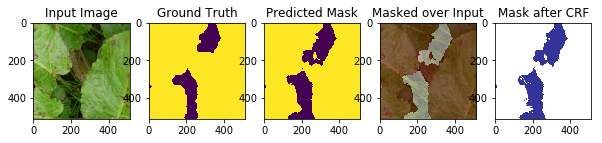

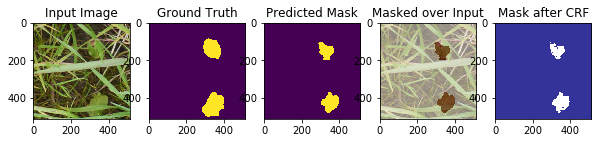

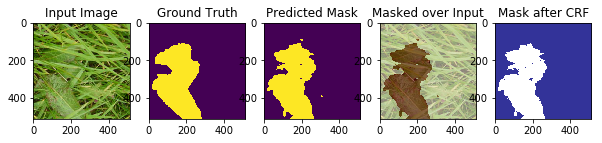

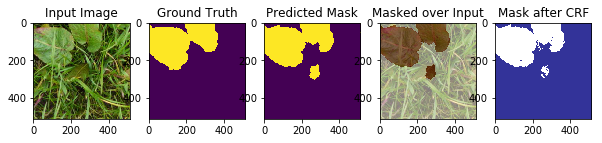

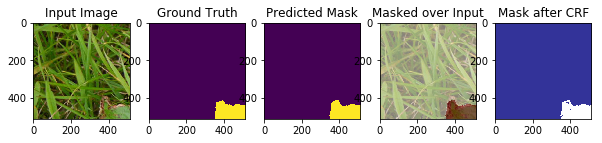

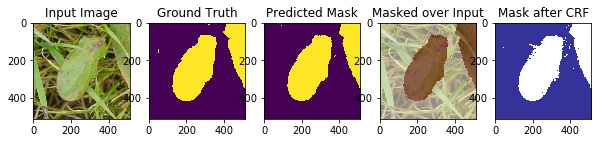

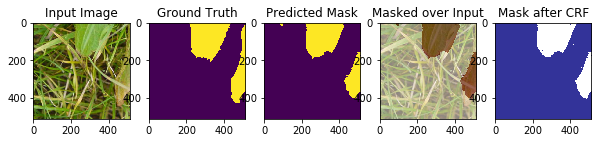

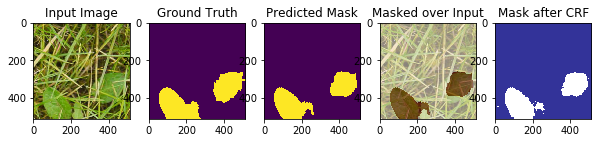

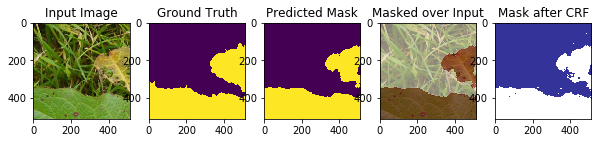

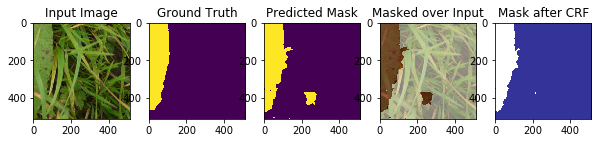

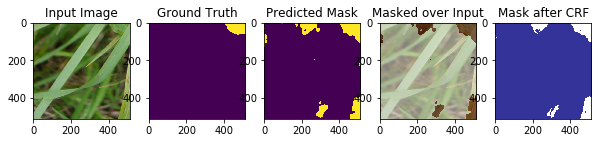

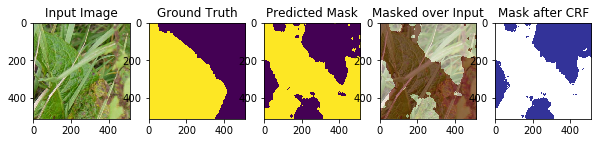

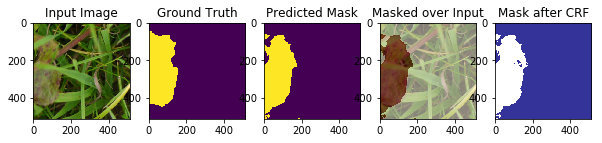

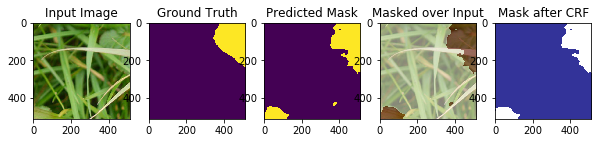

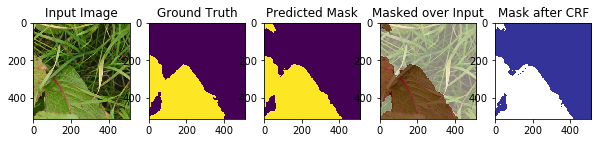

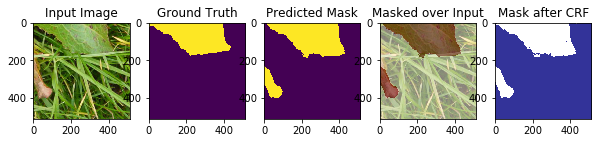

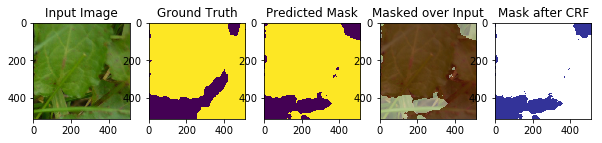

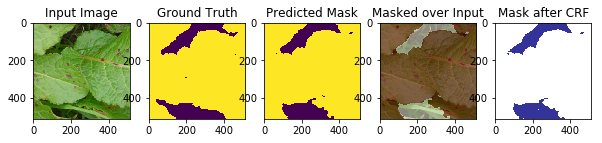

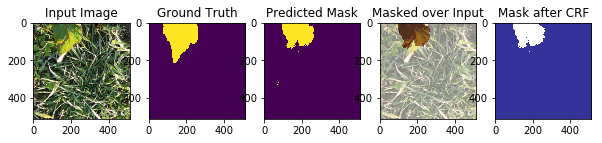

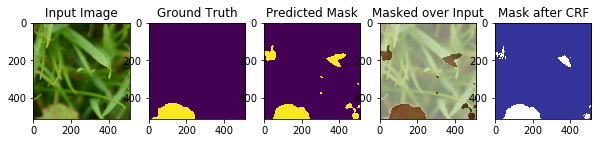

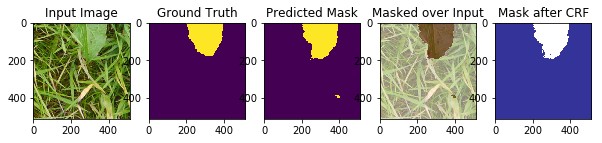

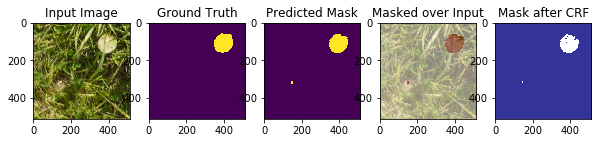

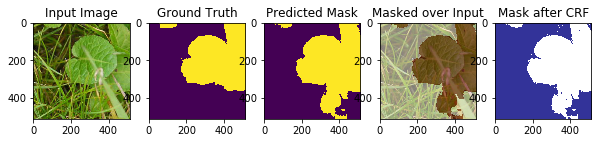

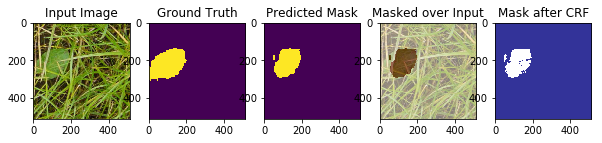

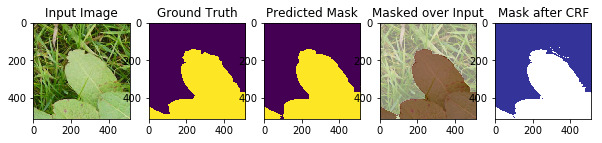

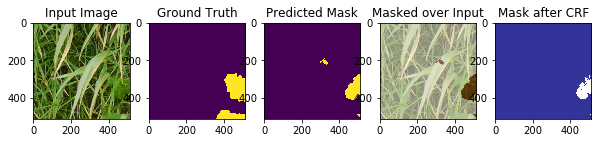

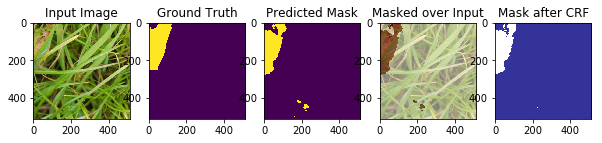

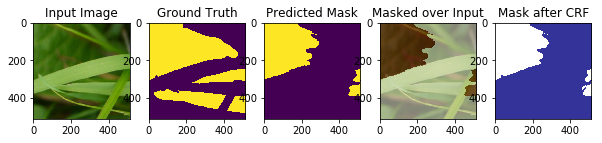

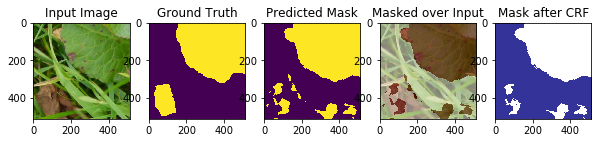

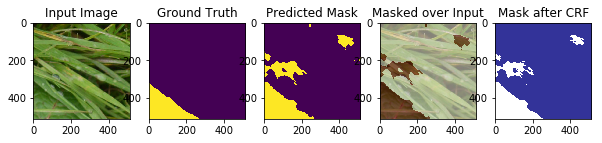

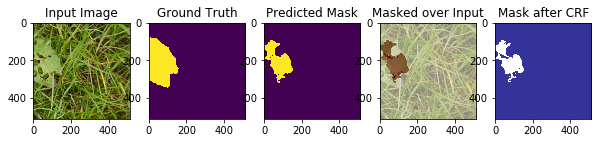

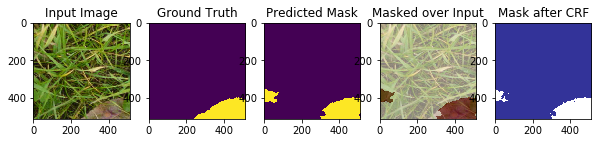

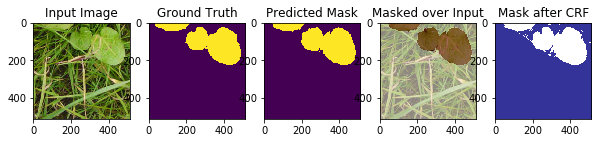

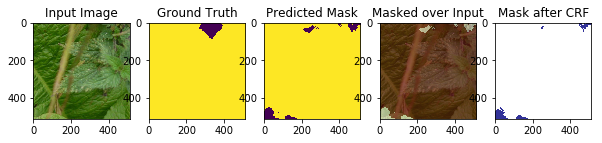

In [27]:
# CRF Post Processing
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2

"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Annotated image = Which has been labelled by some technique( FCN in this case)
#Output_image = The final output image after applying CRF
#Use_2d = boolean variable 
#if use_2d = True specialised 2D fucntions will be applied
#else Generic functions will be applied

def crf(original_image, annotated_image,output_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image)
            
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0] + (annotated_image[:,:,1]<<8) + (annotated_image[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(1)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    imsave(output_image,MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape)
#%%
mean_IOU_before = []
mean_IOU_after = []
for i in range(X_test.shape[0]):
    plt.figure(figsize=(10,2))
    plt.subplot(1,5,1)
    plt.title("Input Image")
    plt.imshow(X_test[i])
    plt.subplot(1,5,2)
    test = np.reshape(Y_test[i], (IMG_SIZE, IMG_SIZE))
    plt.imshow(test)
    plt.title("Ground Truth")
    plt.subplot(1,5,3)
    test = np.reshape(X_test[i], (-1, IMG_SIZE, IMG_SIZE, 3))
    predictions = model.predict(test)
    predictions = np.reshape(predictions, (IMG_SIZE, IMG_SIZE))
    predictions = np.round(predictions)
    plt.imshow(predictions)
    imsave('segmented.png',predictions)
    plt.title("Predicted Mask")
    
    plt.subplot(1,5,4)
    test = np.reshape(Y_test[i], (IMG_SIZE, IMG_SIZE))
    plt.imshow(X_test[i])
    plt.imshow(predictions, 'Reds', alpha=0.5)
    plt.title("Masked over Input")
    intersection = np.logical_and(test, predictions)
    union = np.logical_or(test, predictions)
    iou_score = np.sum(intersection) / np.sum(union)
    #print('IOU Score Before CRF: ' + str(iou_score))
    mean_IOU_before.append(iou_score)
    
    plt.subplot(1,5,5)
    segmented_output = cv2.imread('segmented.png')
    post_crf = crf(X_test[i],segmented_output,"crf1.png")[:,:,0]
    post_crf[post_crf == 84] = 0
    post_crf[post_crf == 36] = 1
    plt.imshow(post_crf, 'terrain')
    plt.title("Mask after CRF")
    intersection = np.logical_and(test, post_crf)
    union = np.logical_or(test, post_crf)
    iou_score = np.sum(intersection) / np.sum(union)
    #print('IOU Score After CRF: ' + str(iou_score))
    mean_IOU_after.append(iou_score)

print('Mean IOU Score Before CRF: ' + str(np.mean(mean_IOU_before)))
print('Mean IOU Score After CRF: ' + str(np.mean(mean_IOU_after)))
print('Min IOU Score Before CRF: ' + str(np.min(mean_IOU_before)))
print('Min IOU Score After CRF: ' + str(np.min(mean_IOU_after)))
print('Max IOU Score Before CRF: ' + str(np.max(mean_IOU_before)))
print('Max IOU Score After CRF: ' + str(np.max(mean_IOU_after)))